Esse projecto visa explorar um conjunto de dados dedicado ao custo do tratamento de diferentes pacientes, extrair insights e obter evidências estatísticas para responder à dúvidas de negócio. Não temos dados sobre o diagnóstico dos pacientes, mas temos outras informações que podem nos ajudar a tirar uma conclusão sobre a saúde dos pacientes e praticar a análise de regressão.   

O custo do tratamento depende de muitos fatores: diagnóstico, tipo de clínica, cidade de residência, idade e assim por diante. Portanto, irei explorar alguns dos fatores que levam a altos gastos e o que pode ser feito para reduzir, de forma que as soluções possam ser benéficos tanto para a empresa de seguros médicos quanto para o beneficiário.  

Também irei explorar a predição do custo de novos pacientes, baseado nas características presentes no conjunto de dados. Uma observação válida sobre o dataset: não há indícios de que os dados aqui presentes são reais. Entretanto, há uma discussão no Kaggle supondo fictícios e baseados em dados da US Census Bureau. No repositório do GitHub do autor do livro, não é referenciado o link fonte do dataset. 

Esse projeto foi criado aplicando a metodologia CRISP-DM.
<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/1200px-CRISP-DM_Process_Diagram.png" width="500" height="400">

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from tabulate import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import pprint

warnings.filterwarnings('ignore')
sns.set(style="darkgrid")

# Data Understanding

In [11]:
df = pd.read_csv("insurance.csv")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [13]:
summary = [
    ["Rows", df.shape[0]],
    ["Columns", df.shape[1]],
    ["Missing Values", df.isnull().sum().sum()],
]

print(tabulate(summary, headers=["Property", "Value"], tablefmt="fancy_grid"))

print("\nFeatures:")
print(tabulate([df.columns], tablefmt="fancy_grid"))

print("\nUnique Values per Column:")
print(tabulate(df.nunique().reset_index().values, headers=["Column", "Unique Values"], tablefmt="fancy_grid"))


╒════════════════╤═════════╕
│ Property       │   Value │
╞════════════════╪═════════╡
│ Rows           │    1338 │
├────────────────┼─────────┤
│ Columns        │       7 │
├────────────────┼─────────┤
│ Missing Values │       0 │
╘════════════════╧═════════╛

Features:
╒═════╤═════╤═════╤══════════╤════════╤════════╤═════════╕
│ age │ sex │ bmi │ children │ smoker │ region │ charges │
╘═════╧═════╧═════╧══════════╧════════╧════════╧═════════╛

Unique Values per Column:
╒══════════╤═════════════════╕
│ Column   │   Unique Values │
╞══════════╪═════════════════╡
│ age      │              47 │
├──────────┼─────────────────┤
│ sex      │               2 │
├──────────┼─────────────────┤
│ bmi      │             548 │
├──────────┼─────────────────┤
│ children │               6 │
├──────────┼─────────────────┤
│ smoker   │               2 │
├──────────┼─────────────────┤
│ region   │               4 │
├──────────┼─────────────────┤
│ charges  │            1337 │
╘══════════╧════════════════

## Panorama do dataset

**Variáveis categóricas**: sex, smoker, region, children  
**Variáveis quantitativas**: age, bmi, charges  

**Não há valores nulos.**  

Por mais que a princípio as variáveis **age**, **smoker**, **region** e **children**, estejam sendo representadas por variáveis do tipo **object** e **int**, respectivamente, elas serão convertidas em categóricas para otimizar armazenamento de dados. Isso porque o tipo de dados `Categorical` aloca memória com base na quantidade de categorias mais o tamanho do string de cada categoria, conforme descrito pela documentação do [pandas](https://pandas.pydata.org/docs/user_guide/categorical.html#gotchas). O tipo de variável `object`, anterioremnte atribuído, é uma constante que multiplicada pelo tamanho da string, aloca o resultado como custo da memória.

# Data Preparation

In [14]:
df["sex"] = df['sex'].astype("category")
df['smoker'] = df['smoker'].astype("category")
df['region'] = df['region'].astype("category")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


Podemos perceber uma diminuição de **73.3+ KB** para **46.3 KB**

# Modeling

## Descrição estatística - variáveis quantitativas

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


### Considerações

- Alta variabilidade nas idades e despesas.  
- A idade média é 39.2 anos e a idade máxima é 64.  
- Média de 30.66 de IMC (Índice de Massa Corporal), considerada fora dos padrões normais. O IMC máximo é de 53.13.
- Gasto médio com custos de saúde em 13.270 K, mediana de 9.382 K e valor máximo gasto de 633.770 K. Temos uma assimetria positiva. A maioria possuem gastos menores do que a minoria. Este é o cenário que encontramos na renda populacional, por exemplo.

<center><img src="https://lh4.googleusercontent.com/proxy/AoLxdW6n96JG-yBf68h9D1uS7zgmIXVgWsyrslSVDN4iAjdFtcAZu-ZFyQHoarTunzJZYGArD9OhFRaTZhN196idh9pofGA573b7tmpQWXY_I07GGyQAfeJvLw" width="500" height="400">

## Descrição estatística - variáveis qualitativas

In [17]:
df.describe(include="category").T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


### Considerações  

- Os homens aparecem com mais frequência. Mas essa frequência é bem distante das mulheres?
- O número de não fumantes é maior. Mas essa frequência é bem distante dos fumantes?
- A região que mais possui custos é a sudeste.

Vamos observar essa diferenças de frequências na Análise Exploratória de Dados

## Análise Exploratória de Dados

### Distribuição das variáveis quantitativas

In [18]:
def distribution_box_graph(data):

    name = data.name.upper()
    fig, (ax_box, ax_dis) = plt.subplots(2, 1, gridspec_kw = {"height_ratios": (.25, .75)}, figsize=(8, 5))
    
    mean = data.mean()
    median = data.median()
    mode = data.mode().tolist()[0]
    
    fig.suptitle(name, fontsize=18, fontweight='bold')
    
    sns.boxplot(x=data, showmeans=True, orient='h', color="darkslateblue", ax=ax_box)
    ax_box.set(xlabel='')
    
    sns.distplot(data, kde=False, color='royalblue', ax=ax_dis)
    
    ax_dis.axvline(mean, color='r', linestyle='--', linewidth=2)
    ax_dis.axvline(median, color='g', linestyle='-', linewidth=2)
    ax_dis.axvline(mode, color='b', linestyle='-', linewidth=2)
    
    plt.legend({'Mean':mean, 'Median':median, 'Mode':mode})

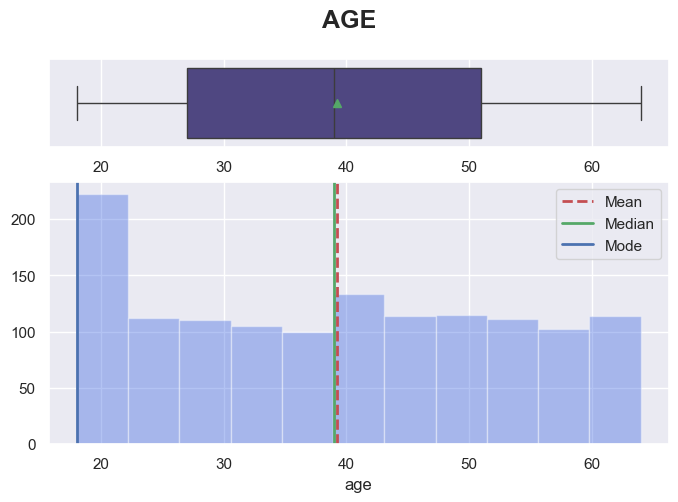

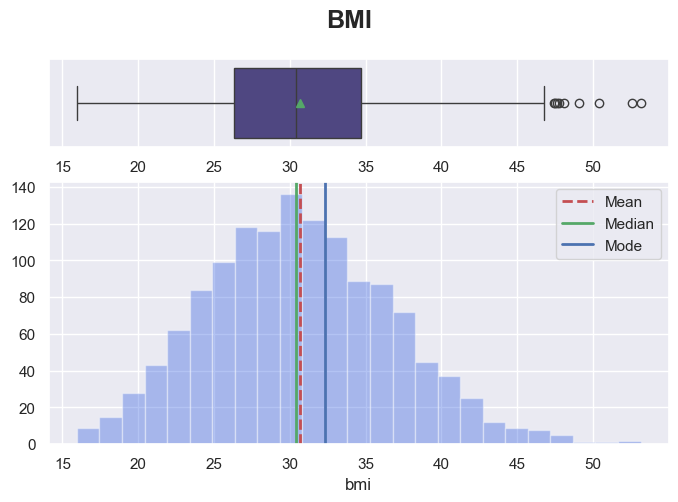

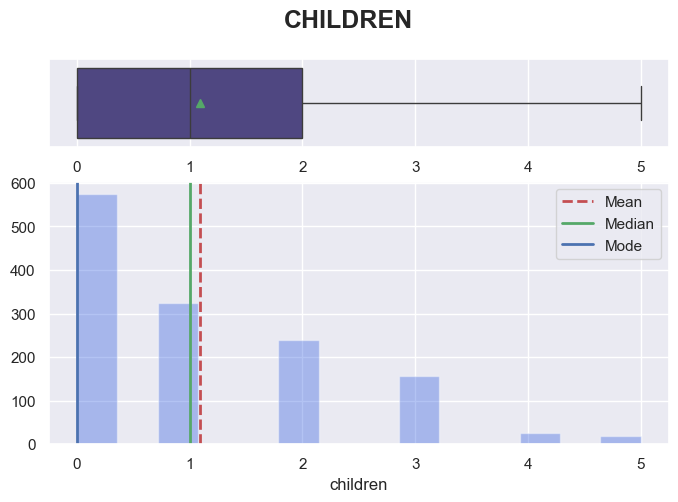

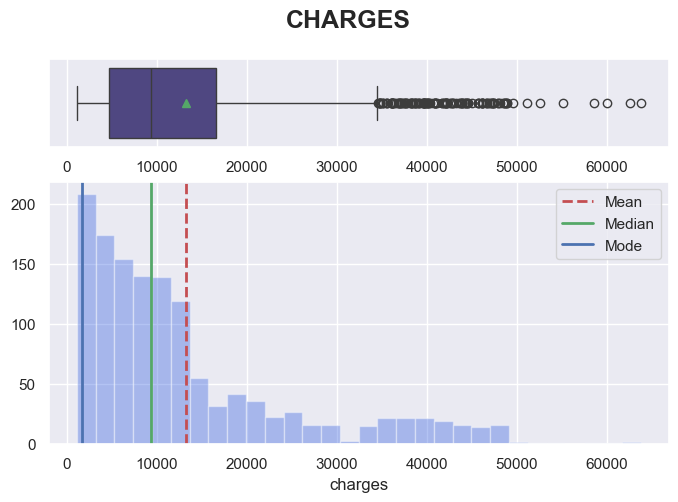

In [19]:
columns = df.select_dtypes([pd.Float64Dtype, pd.Int64Dtype]).columns.to_list()
for col in range(len(columns)):
    distribution_box_graph(df[columns[col]])

- **Age**: Os indivíduos entre 18 e 20 anos são maioria.  
- **BMI**: O gráfico de BMI apresenta uma distribuição aproximadamente simétrica, isto é, apresenta graficamente a característica de uma distribuição normal. Os valores atípicos estão na cuda à direita.  
- **Children**: A maioria dos beneficiários não possuem filhos.  
- **Charges**: Também apresenta valores atípicos na cauda à direita.  

### Proporção das variáveis categóricas

In [20]:
def proportion_bar(plot, feature):
    total = len(feature) # length of the column
    
    for p in plot.patches:
        percentage = f'{100 * p.get_height()/total:.1f}%' # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        plot.annotate(percentage, (x, y), size = 12) # annotate the percentage

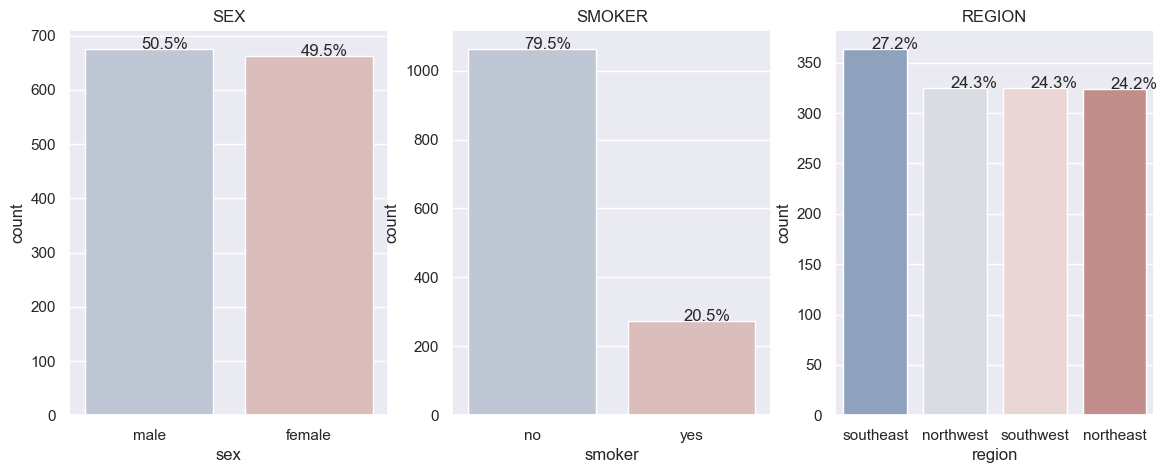

In [21]:
columns = df.select_dtypes(['category']).columns.to_list()
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
for col in range(len(columns)):
    order = df[columns[col]].value_counts(ascending=False).index # to display bar in ascending order
    axis=sns.countplot(x=columns[col], data=df, order=order, ax=axes[col], palette='vlag').set(title=columns[col].upper())
    proportion_bar(axes[col], df[columns[col]])

- A diferença entre homens e mulheres é bem pequena.
- A quantidade de não fumantes é consideravelmente maior que fumantes
- A região com mais gastos é a sudeste, embora o restante apresente um padrão uniforme.

### Correlação

Podemos fazer uma série de suposições a respeito da relação que as features do nosso dataset possuem, dentre elas:
1. A relação entre gastos com despesas médicas e a idade é positiva? 
2. A relação entre gastos com despesas médicas e o IMC é positivo?

Será que essas suposições refletem a realidade dos dados? Lembrando que correlação não implica em causalidade. Essa análise mede somente a relação e a força entre as variáveis.

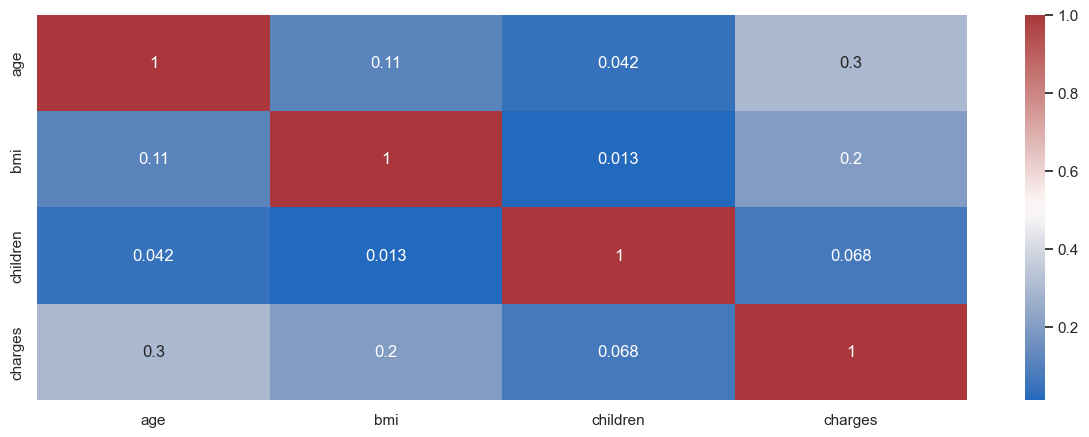

In [22]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="vlag")
plt.show()

Podemos ver que existe uma relação positiva entre `charges` -> `age` e `bmi`, embora a força não seja tão grande para essa amostra. Podemos fazer um teste de hipótese para sustentar nossa afirmação. Antes, precisamos verificar se os dados de charges, age e bmi seguem uma distribuição normal, como parte da premissa para o teste de correlação.

In [23]:
if stats.shapiro(df["charges"])[1] < 0.05:
    print("Há evidências o suficiente para rejeitar H0. Os dados não seguem uma normal.")
else:
    print("Não há evidências o suficiente para rejeitar H0. Os dados seguem uma normal.")

Há evidências o suficiente para rejeitar H0. Os dados não seguem uma normal.


In [24]:
if stats.shapiro(df["bmi"])[1] < 0.05:
    print("Há evidências o suficiente para rejeitar H0. Os dados não seguem uma normal.")
else:
    print("Não há evidências o suficiente para rejeitar H0. Os dados seguem uma normal.")

Há evidências o suficiente para rejeitar H0. Os dados não seguem uma normal.


In [25]:
if stats.shapiro(df["age"])[1] < 0.05:
    print("Há evidências o suficiente para rejeitar H0. Os dados não seguem uma normal.")
else:
    print("Não há evidências o suficiente para rejeitar H0. Os dados seguem uma normal.")

Há evidências o suficiente para rejeitar H0. Os dados não seguem uma normal.


### Testando hipóteses

1. As solicitações de despesas médicas de pessoas que fumam é maior que as solicitações de não fumantes?
2. Há diferença entre as médias de IMC de mulheres e homens?
3. A proporção de fumantes e não fumantes entre diferentes regiões?
4. A média de IMC para mãe com um, dois filhos ou sem filhos é diferente ou é igual?

#### 1. As solicitações de despesas médicas de pessoas que fumam é maior que as solicitações de não fumantes?

<div class ="alert alert-block alert-danger">
    <font size=3><b>Passo 1: definindo a hipótese nula e alternativa</b></font><br>
$\ H_0  :  \mu_1 <= \mu_2  $: A média de gastos de fumantes é menor que ou igual aos não fumantes
<br>$\ H_a  :\mu_1 > \mu_2 $: A média de gastos de fumantes é maior que os não fumantes <br>
</div>

<div class ="alert alert-block alert-danger">
    <font size=3><b>Passo 2: estabelecer o nível de significância. Se o p-valor < significância, então rejeitamos H0.</b></font>

α = 0.05

In [26]:
alpha = 0.05

<div class ="alert alert-block alert-danger">
    <font size=3><b>Passo 3: identificando o teste</b></font>

Queremos avaliar dois grupo: **fumantes** e **não fumantes**; e não há conhecimento sobre o desvio-padrão populacional (como já é esperado). O tipo de teste é **independente**, uma vez que os indivíduos de ambas as amostras não estão relacionados, portanto, conclu-se que deve ser usado o **Teste t de Student**. Resta saber se a variância entre os grupos é **homocedastica (iguais)** ou **heterocedasticas (diferentes)**. Para isso, irei usar o **Teste de Barlett**.  

Outra informação importante é entender qual porção da cauda será usada. A pergunta se referente a identificar se um grupo é maior que outro, logo, o teste será **unicaudal à direita**.

<div class ="alert alert-block alert-danger">
<font size=3><b>Passo 4: calcular o Teste t de Student, Teste de Barlett e o p-valor</b></font>

**Teste t de Student**: será usado para avaliar a média para dois groups  
**Teste de Barlett**: será usado para avaliar se a variância entre os grupos é igual ou diferente.  
**p-valor**: é a probabilidade de observarmos uma estatística de teste igual ou tão extremo ao obtido, sob a hipótese nula.

##### Gerando os grupos  

Como há uma grande diferença na quantidade de dados entre a quantidade não fumantes, irei gerar uma amostra aleatória com a função `sample`, que deve resultar na mesma quantidade presente no conjunto de fumantes.

In [27]:
def generate_smokernosmoker_groups(df):
    smoker = df.loc[df["smoker"]=="yes"]

    nonsmoker = df.loc[df["smoker"]=='no']
    nonsmoker = nonsmoker.sample(smoker.count()[0], random_state=42)

    return smoker, nonsmoker

In [28]:
def generate_smokernonsmoker_charges(smoker, nonsmoker):
    
    smoker_charges = smoker["charges"]
    nonsmoker_charges = nonsmoker["charges"]

    return smoker_charges, nonsmoker_charges

In [29]:
def normal_test(data):
    
    if stats.shapiro(data)[0] < alpha:
        response = "Há evidências para rejeitar H0. Os dados não são normalmente distribuídos"
    else:
        return stats.shapiro(data)[0]

In [30]:
def variance_test(A, B):
    if stats.bartlett(A, B)[0] < alpha:
        response = "Não há evidências para rejeitar H0. As variâncias não são iguais"
        return response, True
    else:
        response = "Não há evidências para rejeitar H0. As variâncias são iguais"
        return response, False

In [31]:
smoker, nonsmoker = generate_smokernosmoker_groups(df)
smoker_charges, nonsmoker_charges = generate_smokernonsmoker_charges(smoker, nonsmoker)

print(f"Média de custo para fumantes: {smoker_charges.mean()}\nMédia de custo para não fumantes: {nonsmoker_charges.mean()}\n")
print("="*50, end="\n\n")

if isinstance(normal_test(smoker_charges), float) & isinstance(normal_test(nonsmoker_charges), float):
    print("Ambas as amostras possuem distribuição normal")
elif isinstance(normal_test(smoker_charges), float) & isinstance(normal_test(nonsmoker_charges), str):
    print("Somente a distribuição de fumantes é normalmente distribuída.")
elif isinstance(normal_test(smoker_charges), str) & isinstance(normal_test(nonsmoker_charges), float):
    print("Somente a distribuição de não fumantes é normalmente distribuída.")
else:
    print("Ambas as distribuições não são normalmente distribuídas.")

print(f"Smoker Charge - P-valor: {normal_test(smoker_charges)}")
print(f"Nonsmoker Charge - P-valor: {normal_test(nonsmoker_charges)}\n")
print("="*50, end="\n\n")

response, variance = variance_test(smoker_charges, nonsmoker_charges)

stat_test, pvalue = stats.ttest_ind(a=smoker_charges, b=nonsmoker_charges, equal_var=variance, alternative="greater")

if pvalue < alpha:
    print("Há evidências para rejeitar H0. A média de gastos com despesas médicas não é menor para não fumantes.")
else:
    print("Não há evidências para rejeitar H0.")

Média de custo para fumantes: 32050.23183153284
Média de custo para não fumantes: 8335.549181021897


Ambas as amostras possuem distribuição normal
Smoker Charge - P-valor: 0.9395519386965634
Nonsmoker Charge - P-valor: 0.8859906182043192


Há evidências para rejeitar H0. A média de gastos com despesas médicas não é menor para não fumantes.


<div class ="alert alert-block alert-danger">
    <font size=3><b>Passo 5: decidir o resultado do teste de acordo com a estatística de teste e p-valor</b></font><br>    
    Rejeita-se a hipótese nula e pode conclui-se que as pessoas que fumam têm, em média, maiores gastos médicos em comparação com as pessoas que não fumam.

### 4. A média de IMC para mãe com um, dois filhos ou sem filhos é diferente ou é igual?

In [32]:
df_female_child = df.loc[df['children']<=2]

formula = 'bmi ~ C(children)'
model = ols(formula, df_female_child).fit()
aov_table = anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(children),2.0,31.631915,15.815957,0.416983,0.659133
Residual,1135.0,43049.991501,37.929508,NaN,NaN


## Desenvolvendo o modelo  

O modelo de regressão linear será modelado para a equação da reta:  

In [48]:
model = ols("charges ~ age + sex + smoker + region  + bmi + children", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Mon, 20 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:16:07   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.194e+04    

## Obtendo estimadores BLUE

### 1) Linearidade nos parâmetros  

É especificado pelo modelo:  

$charges = B_0 + B_1 * age + B_2 * sex + B_3 * smoker + B_4 * region + B_5 * bmi + B_6 * children$

### 2) A média do termo de erro é igual a zero  

In [50]:
model.resid.mean().round(2)

np.float64(-0.0)

In [33]:
X = df.drop("charges", axis=1)
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((1070, 6), (268, 6))

In [34]:
categorical_features = X_train.select_dtypes(include=["category"]).columns.to_list()
numerical_features = X.select_dtypes(exclude=["category"]).columns.to_list()
categorical_features, numerical_features

(['sex', 'smoker', 'region'], ['age', 'bmi', 'children'])